In [49]:
from sirum.models import sir_model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Stable beta

In [5]:
beta_0 = 0.9
gamma = 1./10

In [6]:
sir = sir_model.SIR(beta_0=beta_0, gamma=gamma)

In [7]:
N = 15e6
I_0, R_0 = 100, 0
S_0 = N - I_0 - R_0
days = 90

In [10]:
sir.solve_ODE(Initial_vals=[S_0,I_0,R_0], days=days);

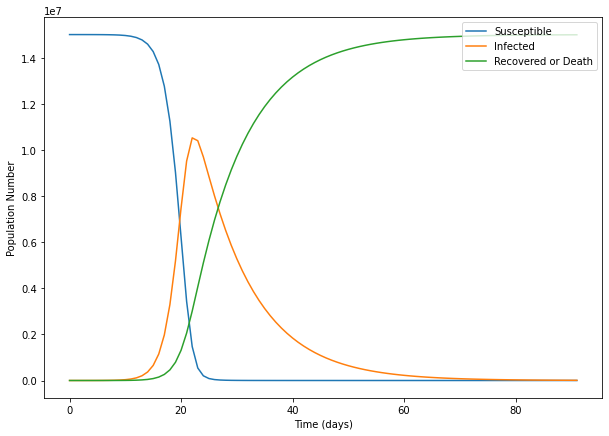

In [11]:
sir.plot()

## Variable beta

In [30]:
beta_changepoints = [(10, 0.7),
                     (16, lambda x: np.maximum(0.5 - 0.02*(x-x[0]), 0.2)),
                     (40, lambda x: np.minimum(0.5 + 0.04*(x-x[0]), beta_0)) ]

In [31]:
sir = sir_model.SIR(beta_0=beta_0, beta_changepoints=beta_changepoints, gamma=gamma)

In [32]:
sir.solve_ODE(Initial_vals= [S_0,I_0,R_0], days=days);

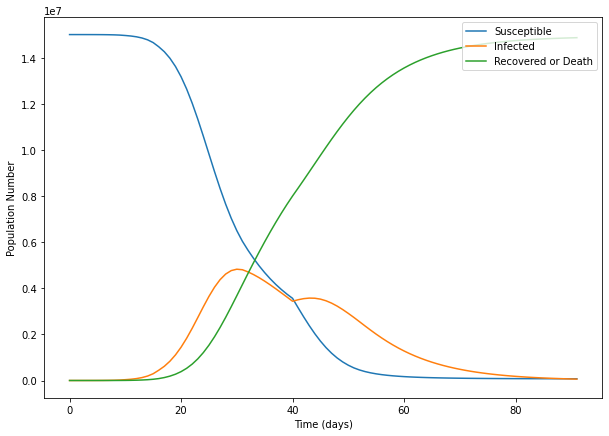

In [33]:
sir.plot()

## Fitting to actual data

In [40]:
from sirum import data as sirum_data

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
from scipy.optimize import differential_evolution as devo

In [61]:
# load in US data
SIR_data = sirum_data.CovidDataSelection(country='US')
US_data = SIR_data.create_data()

US_data['S'] = 330e6-US_data['deaths']-US_data['recovered']-US_data['cases'].values[:,0]
US_data['I'] = US_data['cases'].values[:,0]
US_data['R'] = 0+US_data['deaths']+US_data['recovered']
yobs = US_data[['S', 'I', 'R']].values
num_days = len(yobs)

In [65]:
# apply differential evolution 
# 1. define bounds
BetaBounds = (0.04, 1.)
GammaBounds = (0.005, 0.05) 
S0Bounds = (329e6, 330e6)
I0Bounds = (0, 1e4)
R0Bounds = (0, 100)
bounds = [BetaBounds, GammaBounds, S0Bounds, I0Bounds, R0Bounds]

# 2. normalise
yobs_norm = yobs/yobs.max(axis=0)

# 3. create wrapper function for the optimisation
beta_0 = 1.1; gamma_0 = 0.1
sir = sir_model.SIR(beta_0, gamma_0, beta_changepoints=None)
def opt_fun(params):
    SIRres = sir.solve_ODE([params[2], params[3], params[4]], num_days-2, params[0], params[1])
    SIRres_norm = SIRres/yobs.max(axis=0)
    error = msle(SIRres_norm, yobs_norm)
    return error

# 4. optimise!
devo_res = devo(opt_fun, bounds, workers=4, maxiter=1000, popsize=100, mutation=0.95, recombination=0.35)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


In [66]:
opt_res =  {'Beta': devo_res.x[0],
             'Gamma': devo_res.x[1],
             'S0': devo_res.x[2],
             'I0': devo_res.x[3],
             'R0': devo_res.x[4]}
opt_res

{'Beta': 0.07679316921100791,
 'Gamma': 0.010442923741637716,
 'S0': 329900265.8342619,
 'I0': 2211.8053413256057,
 'R0': 0.37068089602650106}

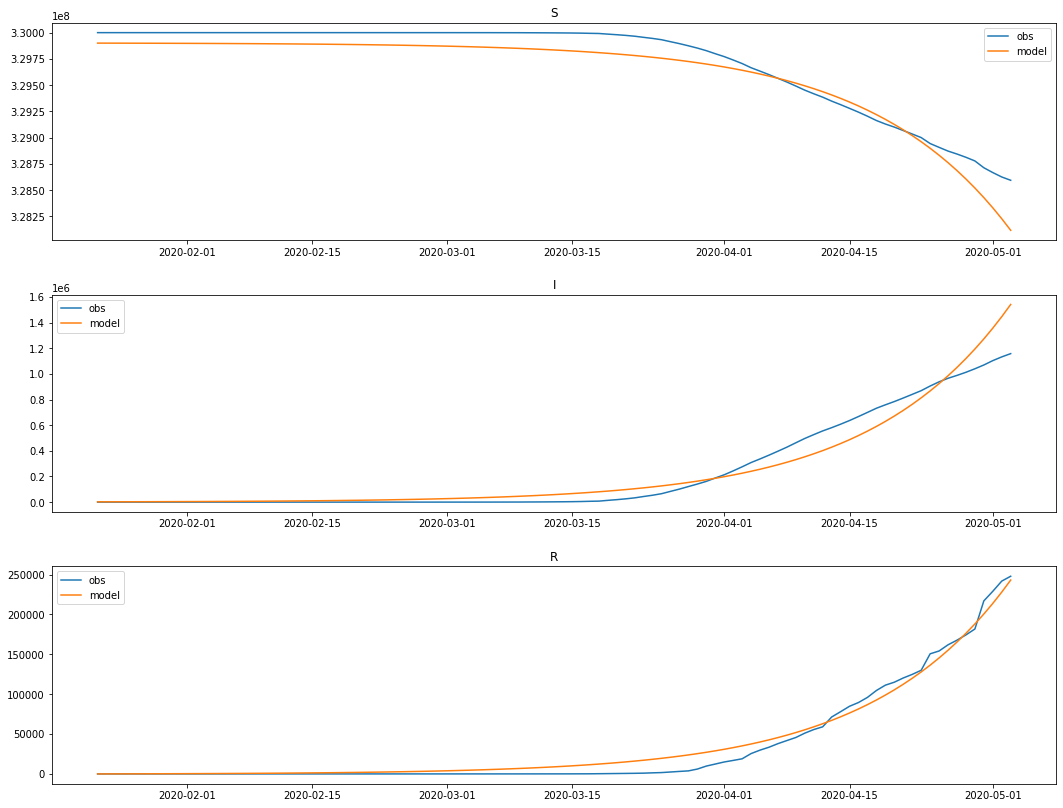

In [67]:
fig, ax = plt.subplots(nrows=3, figsize=(18,14))

model_res = sir.solve_ODE([opt_res['S0'], 
                           opt_res['I0'],
                           opt_res['R0']], 
                           num_days-2, 
                           beta_0=opt_res['Beta'], 
                           gamma=opt_res['Gamma'])

model_res_df = pd.DataFrame(data=model_res, index=US_data.index, columns=['S', 'I', 'R'])

ax[0].plot(US_data['S'], label='obs')
ax[1].plot(US_data['I'], label='obs')
ax[2].plot(US_data['R'], label='obs')
ax[0].plot(model_res_df['S'], label='model')
ax[1].plot(model_res_df['I'], label='model')
ax[2].plot(model_res_df['R'], label='model')


ax[0].set_title("S")
ax[1].set_title("I")
ax[2].set_title("R")

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.subplots_adjust(hspace=0.25)